# Surface Defect Detection for EBA5 Dataset

## 1. Introduction

In this notebook, we are going to create a convolutional neural network (CNN) that can detect surface defects.
Previously we have used Torch but now PyTorch will be used.

PyTorch is the freshest flavour of the Torch. It combines customization of Torch with Python ease of use. It completely covers the Torch functionality, on top of that, new Autograd mechanism, dataset loaders and lots of utilities have been added for convenience.

## 2. Code

First, let's import required packages...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Spectral7
from bokeh.io import output_notebook
#from graphviz import Digraph
import numpy as np
import cnnUtils
import time
import copy
import os
import PIL
%matplotlib inline
plt.ion()
output_notebook()

Please install sklearn for layer visualization


Loading BokehJS ...

## 2.1 Dataset transformations
PyTorch lets us define a set of transformations to the loaded datasets. 

First images are converted to Torch tensors and then we will be scaling the images to 64 pixels in the smaller dimension. 

In [2]:
baseDirectory = 'g:/Selim/Thesis/Code/'
setDirectory = 'EBA'
setImageSize = 128

# EBA5 cropped mean and std values
#0.544978628454
#0.0564096715989
setMean = [0.544, 0.544, 0.544]
setStd = [0.056, 0.056, 0.056]

# EBA5 full mean and std
#Dim 0 mean: 0.558987606566
#Dim 0 stdv: 0.0675306702862
#setMean = [0.558, 0.558, 0.558]
#setStd = [0.067, 0.067, 0.067]

dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.RandomCrop(setImageSize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

## 2.2 Loading datasets
Unlike Torch, PyTorch now supports direct image folder loading as the data. This completely removes the big dataset preparation step.

Additionally new dataset loaders allow setting batch size, shuffle and several other useful parameters.

Lastly checking the CUDA support is now easier with `torch.cuda.is_available()`

In [3]:
setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=10, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )
print(str(len(datasetClasses)) + ' output classes')

{'train': 607, 'test': 311} images will be used.
GPU will be used.
2 output classes


## 2.3 Auxiliary functions

### 2.3.1 ImShow
Here we define the simple image displaying function and use the new dataset iterator to get one random batch to display it.

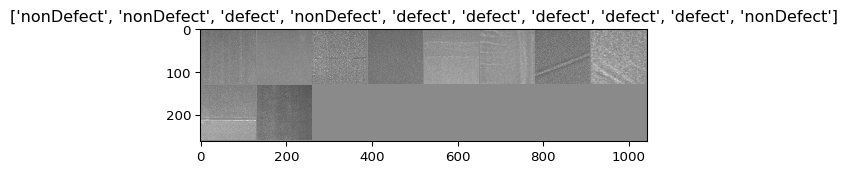

In [4]:
inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)

cnnUtils.ImShow(out, mean=setMean, std=setStd, title=[datasetClasses[x] for x in classes])
#print(inputs)

# 2.4 Training functions

This section contains functions used in training the network. First we should create the arrays to keep the error and learning rate changes.

In [5]:
trainLRValues = []
trainAccuracyTrain = []
trainAccuracyTest = []
trainErrorTrain = []
trainErrorTest = []

grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

## 2.5 Definition of neural network

### 2.5.1 Network module
Similar to Torch, here we define the neural network using separate modules.
First module handles the convolutional part of the network. After that a reshape operation adjust the convolution result for the following fully-connected layer module. Lastly, the result is applied to the fully-connected layer of the network and decisions are obtained with LogSoftMax operation in the end.

In [6]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(convInResult))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(convI2Result))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(convI3Result))
        
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x



#### 2.5.1.2 Batch normalization - TEST

In [7]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI2 = nn.BatchNorm2d(num_features=32)
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.4 Batch normalization + SELU + AlphaDropout

In [8]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class NetBNSELU(nn.Module):
    def __init__(self):
        super(NetBNSELU, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.seluIn = SELU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI2 = nn.BatchNorm2d(num_features=32)
        self.seluI2 = SELU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.seluI3 = SELU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            SELU(),
            AlphaDropout(p=0.5),
            nn.Linear(4096, 4096),
            SELU(),
            AlphaDropout(p=0.5),
            nn.Linear(4096, 4096),
            SELU(),
            AlphaDropout(p=0.5),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.seluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.seluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.seluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.5 BN + Optim

In [9]:
class NetBNOptim(nn.Module):
    def __init__(self):
        super(NetBNOptim, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.6 DilateNet

In [10]:
class NetDilate(nn.Module):
    def __init__(self):
        super(NetDilate, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(6,6), dilation=(3,3))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=(6,6), dilation=(3,3))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(6,6), dilation=(3,3))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.7 DilateStrideNet

In [11]:
class NetDilateStride(nn.Module):
    def __init__(self):
        super(NetDilateStride, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        #self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.reluI2 = nn.ReLU()
        #self.poolI2 = nn.MaxPool2d(2, 2)
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        #self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.reluIn(self.batNIn(convInResult))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.reluI2(self.batNI2(convI2Result))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.reluI3(self.batNI3(convI3Result))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.8 DSPlusNet

In [13]:
def GetMatchingLayer(inChannels, outChannels, stride=(2,2), padding=(0,0)):
    return nn.Sequential(
            nn.Conv2d(in_channels=inChannels, out_channels=outChannels, kernel_size=(1,1), stride=stride, padding=padding),
            #nn.BatchNorm2d(num_features=outChannels)
    ).cuda()

class DSPlusNet(nn.Module):
    def __init__(self):
        super(DSPlusNet, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.reluI2 = nn.ReLU()
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        #  Get the residual, match it to the output
        #plus01 = GetMatchingLayer(self.convIn.in_channels, self.convIn.out_channels)(x)
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        #  Add the residual before activation function
        x = self.reluIn(self.batNIn(convInResult)) #  + plus01
        
        # Convolutional layer 2
        #  Get the residual, match it to the output
        #plus02 = GetMatchingLayer(self.convI2.in_channels, self.convI2.out_channels)(x)
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        #  Add the residual before activation function
        x = self.reluI2(self.batNI2(convI2Result)) # + plus02
        
        # Convolutional layer 3
        #  Get the residual, match it to the output
        #plus03 = GetMatchingLayer(self.convI3.in_channels, self.convI3.out_channels)(x)
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        #  Add the residual before activation function
        x = self.reluI3(self.batNI3(convI3Result)) #  + plus03
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

Now let's initialize the network and use GPU if possible.

In [14]:
# Regular net
#net = Net()

# Net with batch normalization layers, added approx ~1m per 10 epochs
#net = NetBN()

# Net with BN + SELU + AlphaDropout
#net = NetBNSELU()

# A smaller Net with batch normalization
#net = NetSmallBN()

# BN with optimized params
#net = NetBNOptim()

# Net with dilated convolutions
#net = NetDilate()

# Net with dilated conv + 2 stride and removed pooling layers
#net = NetDilateStride()

# Net with dilation, stride, residuals and ELU as output
net = DSPlusNet()

#net = models.resnet50(pretrained=False)

if useGPU:
    net = net.cuda()

### 2.5.2 Criterion and optimizer
We successfully created our neural network. Now it is time to define a loss function and the optimizer.

In [15]:
criterion = nn.CrossEntropyLoss()
# try 0.03 weight_decay
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01, nesterov=True)
#optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
#optimizer = optim.Adagrad(net.parameters(), lr=0.001, weight_decay=0.001)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=0.01)

lrScheduler = cnnUtils.StepLR(optimizer, step_size=3, gamma=0.85)

if useGPU:
    criterion = criterion.cuda()

## 2.6 Training

Mini-batch training method is preferred with PyTorch. It converges faster than the batch training method.

*Example*

*Mini-batch : With GTX 1070, 50 epochs train in 6m8s with 92.1% train and 93.9% test accuracy.*

*Batch      : With GTX 1070, 80 epochs train in 7m32s with 98.5% train and 99.3% test accuracy.*

In [16]:
cnnUtils.TrainModelMiniBatch(net, criterion, optimizer, lrScheduler, datasetLoaders, datasetSizes, trainAccuracyTrain, trainAccuracyTest, trainLRValues, 
                    trainErrorTrain, trainErrorTest, num_epochs=10)   

Epoch 0/9
----------
LR: [0.00011764705882352942]
train Loss: 0.0634 Acc: 0.6606
test Loss: 0.0897 Acc: 0.6656

Epoch 1/9
----------
LR: [0.0001]
train Loss: 0.0469 Acc: 0.7957
test Loss: 0.0393 Acc: 0.8039

Epoch 2/9
----------
LR: [0.0001]
train Loss: 0.0355 Acc: 0.8517
test Loss: 0.0355 Acc: 0.8392

Epoch 3/9
----------
LR: [0.0001]
train Loss: 0.0310 Acc: 0.8600
test Loss: 0.0215 Acc: 0.9164

Epoch 4/9
----------
LR: [8.5e-05]
train Loss: 0.0294 Acc: 0.8699
test Loss: 0.0228 Acc: 0.9132

Epoch 5/9
----------
LR: [8.5e-05]
train Loss: 0.0276 Acc: 0.8962
test Loss: 0.0350 Acc: 0.8521

Epoch 6/9
----------
LR: [8.5e-05]
train Loss: 0.0252 Acc: 0.8929
test Loss: 0.0161 Acc: 0.9453

Epoch 7/9
----------
LR: [7.225e-05]
train Loss: 0.0206 Acc: 0.9094
test Loss: 0.0246 Acc: 0.8907

Epoch 8/9
----------
LR: [7.225e-05]
train Loss: 0.0228 Acc: 0.9160
test Loss: 0.0207 Acc: 0.9035

Epoch 9/9
----------
LR: [7.225e-05]
train Loss: 0.0237 Acc: 0.9077
test Loss: 0.0142 Acc: 0.9518

Training com

DSPlusNet (
  (convIn): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6), dilation=(3, 3))
  (batNIn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluIn): ReLU ()
  (convI2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6), dilation=(3, 3))
  (batNI2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (reluI2): ReLU ()
  (convI3): Conv2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6), dilation=(3, 3))
  (batNI3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluI3): ReLU ()
  (fc): Sequential (
    (0): Linear (8192 -> 1024)
    (1): ReLU (inplace)
    (2): Dropout (p = 0.5)
    (3): Linear (1024 -> 1024)
    (4): ReLU (inplace)
    (5): Dropout (p = 0.5)
    (6): Linear (1024 -> 1024)
    (7): ReLU (inplace)
    (8): Linear (1024 -> 2)
  )
  (logsmax): LogSoftmax ()
)

NetDilateStride (
  (convIn): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6), dilation=(3, 3))
  (batNIn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluIn): ReLU ()
  (convI2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6), dilation=(3, 3))
  (batNI2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (reluI2): ReLU ()
  (convI3): Conv2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6), dilation=(3, 3))
  (batNI3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluI3): ReLU ()
  (fc): Sequential (
    (0): Linear (8192 -> 1024)
    (1): ReLU ()
    (2): Dropout (p = 0.5, inplace)
    (3): Linear (1024 -> 1024)
    (4): ReLU ()
    (5): Dropout (p = 0.5, inplace)
    (6): Linear (1024 -> 1024)
    (7): ReLU ()
    (8): Dropout (p = 0.5, inplace)
    (9): Linear (1024 -> 2)
  )
  (logsmax): LogSoftmax ()
)


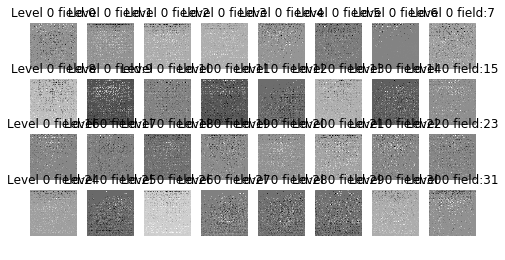

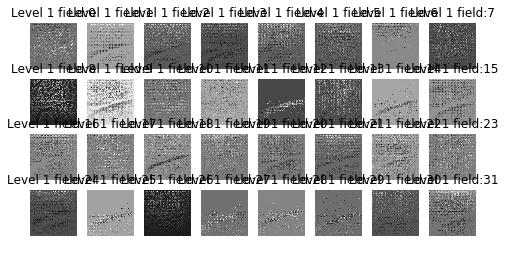

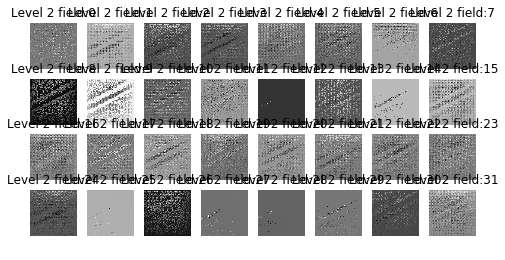

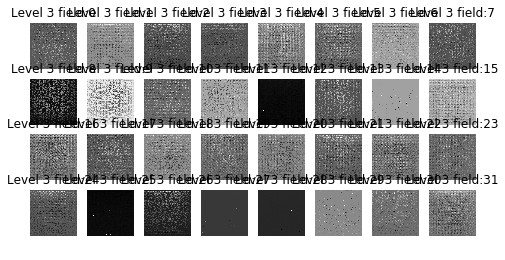

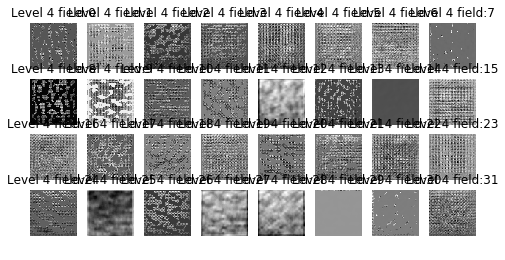

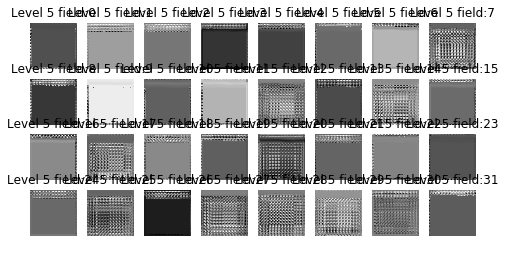

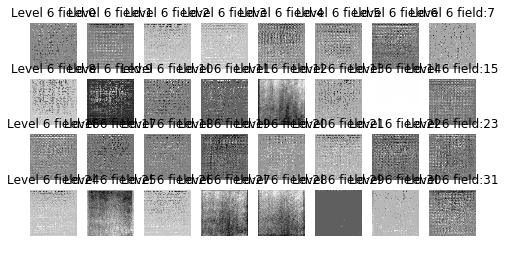

In [16]:
print(net)
gradIn = grads['convInGrad']
gradI2 = grads['convI2Grad']
gradI3 = grads['convI3Grad']


cnnUtils.PlotActivationMaps(gradIn)
#cnnUtils.PlotActivationMaps(gradI2)
#cnnUtils.PlotActivationMaps(gradI3)

### 2.6.3 Visualization of the progress

In [17]:
cnnUtils.PlotArrays([trainErrorTrain, trainErrorTest], ['Training', 'Test'], xlabel='Epoch', ylabel='Loss', title='Loss over epoch')
cnnUtils.PlotArrays([trainLRValues], ['Learning rate'], xlabel='Epoch', ylabel='Learning rate', title='Learning rate decrease')
cnnUtils.PlotArrays([trainAccuracyTrain, trainAccuracyTest], ['Training accuracy', 'Test accuracy'], xlabel='Epoch', ylabel='Accuracy', title='Accuracy increase over epoch')

## 2.7 Visualization of the weights

This section is still in development.

(32, 3, 5, 5)


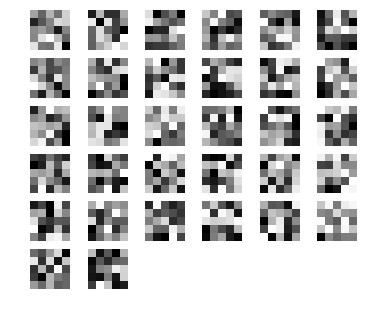

In [18]:
cnnUtils.plotNNFilter(net.convIn.weight.cpu().data.numpy())

## 2.8 Evaluating network accuracy
Let's calculate the accuracy on the training set.

In [19]:
def DetermineAccuracy(phase, datasetLoaders):
    correct = 0
    total = 0
    for data in datasetLoaders[phase]:
        # Inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    return correct, total


correct, total = DetermineAccuracy('train', datasetLoaders)
print('Accuracy of the network for training set is {}%'.format(100 * correct / total))

Accuracy of the network for training set is 93.08072487644152%


Now time to see the accuracy of the test set.

In [20]:
correct, total = DetermineAccuracy('test', datasetLoaders)
print('Accuracy of the network for test set is {}%'.format(100 * correct / total))

Accuracy of the network for test set is 94.21221864951768%


Let's see individual class performance along with the confusion matrix.

Class defect total: 181.0 correct: 178.0 success rate is 98.34254143646409
Class nonDefect total: 130.0 correct: 129.0 success rate is 99.23076923076923


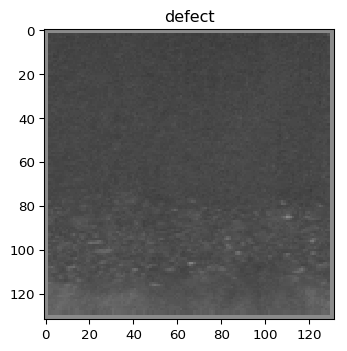

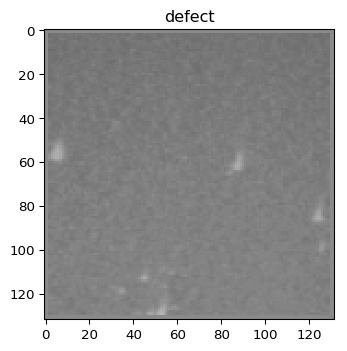

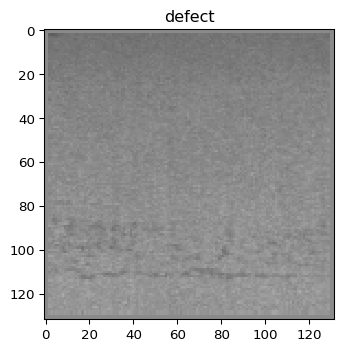

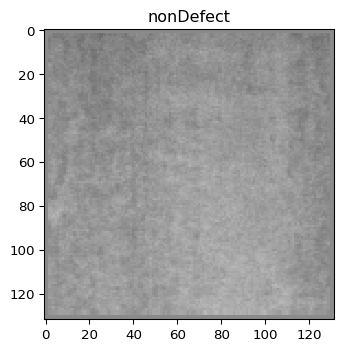

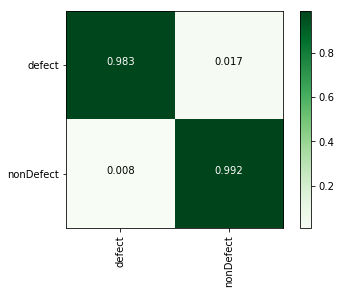

In [37]:
datasetLen = len(datasetClasses)
classCorrect = list(0. for i in range(datasetLen))
classTotal = list(0. for i in range(datasetLen))
confusion = torch.zeros(datasetLen, datasetLen)

for i, data in enumerate(testLoader):
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    classTotal[labels.data.cpu().numpy()[0]] += 1
    confusion[labels.data.cpu().numpy()[0]][predicted[0][0]] += 1
    
    if labels.data.cpu().numpy()[0] == predicted.cpu().numpy()[0][0]:
        classCorrect[labels.data.cpu().numpy()[0]] += 1
    else: # Display failure cases
        out = torchvision.utils.make_grid(inputs.data.cpu())
        cnnUtils.ImShow(out, mean=setMean, std=setStd, title=datasetClasses[labels.data.cpu()[0]])

for i, cls in enumerate(classCorrect):
    print('Class ' + datasetClasses[i] + ' total: ' + str(classTotal[i]) + ' correct: ' + str(classCorrect[i]) + ' success rate is ' + str(100 * classCorrect[i] / classTotal[i])) 

    
# Normalize confusion matrix
for i in range(datasetLen):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
#cax = ax.matshow(confusion.numpy())
plt.imshow(confusion.numpy(), interpolation='nearest', cmap=plt.cm.Greens)
plt.colorbar()

ax.set_xticklabels([''] + datasetClasses, rotation=90)
ax.set_yticklabels([''] + datasetClasses)
thresh = confusion.max() / 2.0

for i in range(confusion.numpy().shape[0]):
    for j in range(confusion.numpy().shape[1]):
        plt.text(j, i, np.around(confusion[i,j], 3), horizontalalignment="center", color="white" if confusion[i, j] > thresh else "black")

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Results are looking good, let's save the model for future use.

In [27]:
torch.save(net, 'EBA5CNN.net')

g:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type NetBN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [1]:
netb = torch.load('EBACNN.net')

NameError: name 'torch' is not defined

#### Forward-pass benchmark

In [30]:
input, label = next(iter(datasetLoaders['train']))
input, label = Variable(input.cuda()), Variable(label.cuda())

startT = time.perf_counter()
outputs = net(input)
endT = time.perf_counter()
_, predicted = torch.max(outputs.data, 1)
    
print(str((endT-startT) * 1000)  + ' ms')

3.894154591885357 ms
